In [1]:
# Denoising Diffusion Probabilistic Model (DDPM)

import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import random
import torch
import numpy as np

seed = 42

random.seed(seed)
torch.manual_seed(seed)

# To make the results reproducable
torch.use_deterministic_algorithms(True)

import torch.nn.functional as F
from torch.optim import Adam, RAdam
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import multiprocessing

from torchvision import transforms
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [2]:
# Dataset

from data import get_dataloader
img_size = 64
batch_size = 32

dataloader = get_dataloader("data/stanford_cars", img_size, batch_size)
    

Using 8 workers


In [3]:
batch, _ = next(iter(dataloader))

In [4]:
# Display the data in the dataloader
def display_sequence(imgs, dpi=75, nrow=8):
    fig, sub = plt.subplots(dpi=dpi)
    sub.imshow(
        np.transpose(
            make_grid(
                imgs,
                padding=0,
                normalize=True,
                nrow=nrow
            ).cpu(),
            (1, 2, 0)
        )
    )
    _ = sub.axis("off")

    return fig

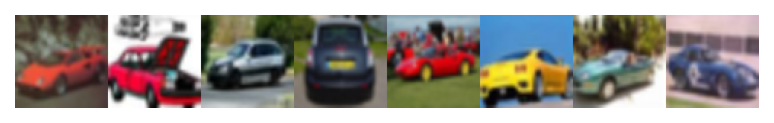

In [5]:
_ = display_sequence(batch[:8], dpi=150)

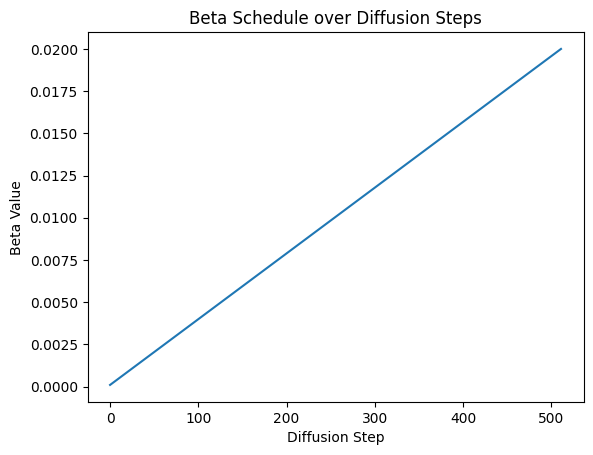

In [6]:
# Noise scheduling and precomputation
# Define beta schedule
T = 512 # Number of diffusion steps

betas = torch.linspace(start=0.0001, end=0.02, steps=T) # Linear schedule

plt.plot(range(T), betas.numpy(), label='Beta Values')
plt.xlabel('Diffusion Step')
plt.ylabel('Beta Value')
_ = plt.title('Beta Schedule over Diffusion Steps')

In [7]:
alphas = 1. - betas
alphas_bar = torch.cumprod(alphas, axis=0)
# Alpha bar at t-1
alphas_bar_prev = F.pad(alphas_bar[:-1], (1, 0), value=1.0)
# sqrt of alpha bar
sqrt_alphas_bar = torch.sqrt(alphas_bar)

In [8]:
# Inference:
# 1 / sqrt(alpha)
sqrt_recip_alphas = torch.sqrt(1.0/alphas)
# Sqrt of 1 - alpha bar
sqrt_one_minus_alpha_bar = torch.sqrt(1 - alphas_bar)
# Sigma_t
posterior_variance = betas * (1. - alphas_bar_prev) / (1. - alphas_bar)

In [9]:
# Utility functions to visualize forward diffusion process, and to make an inference call on an existing DDPM
# Telling the visualizer function that do not calculate gradients for any operations inside this function
@torch.no_grad()
def forward_diffusion_viz(image, device='cpu', num_images=16, dpi=75, interleave=False):
    """
    Generate the forward sequence of noisy images taking the input image to pure noise
    """
    # Visualize only num_images diffusion steps, instead of all of them
    stepsize = int(T/num_images)
    
    imgs = []
    noises = []
    
    for i in range(0, T, stepsize):
        t = torch.full((1, ), i, device=device, dtype=torch.long)
        
        # Forward diffusion process
        bs = image.shape[0]
        noise = torch.randn_like(image, device=device)
        img = (
            sqrt_alphas_bar[t].view(bs, 1, 1, 1) * image + 
            sqrt_one_minus_alpha_bar[t].view(bs, 1, 1, 1) * noise
        )
        
        imgs.append(torch.clamp(img, -1, 1).squeeze(dim=0))
        
    if interleave:
        imgs = [item for pair in zip(imgs, noises) for item in pair]
        
    fig = display_sequence(imgs, dpi=dpi)
    
    return fig, imgs[-1]


@torch.no_grad()
def make_inference(input_noise, device, model, return_all=False):
    """
    Implements the sampling algorithm from the DDPM paper
    """
    x = input_noise
    bs = x.shape[0]
    
    imgs = []
    
    for time_step in range(0, T)[::-1]:
        noise = torch.randn_like(x) if time_step > 0 else 0
        t = torch.full((bs, ), time_step, device=device, dtype=torch.long)
        
        x = sqrt_recip_alphas[t].view(bs, 1, 1, 1) * (
            x - betas[t].view(bs, 1, 1, 1) * model(x, t) / 
            sqrt_one_minus_alpha_bar[t].view(bs, 1, 1, 1)
        ) + torch.sqrt(posterior_variance[t].view(bs, 1, 1, 1)) * noise
        
        imgs.append(torch.clamp(x, -1, 1))
    
    if return_all:
        return imgs
    else:
        return imgs[-1]

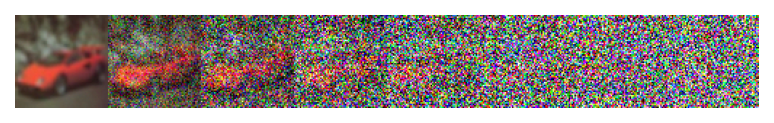

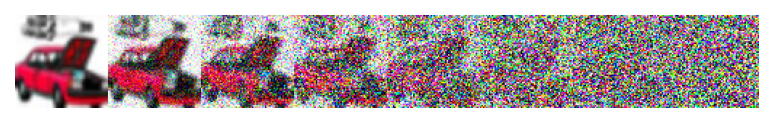

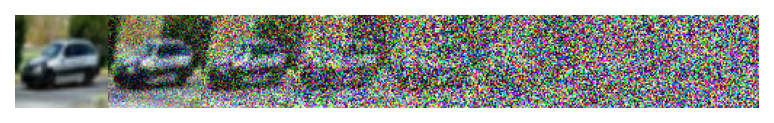

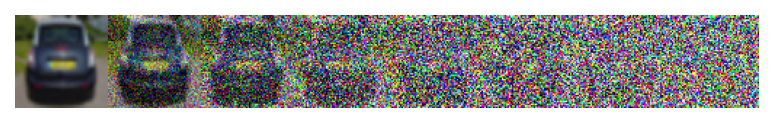

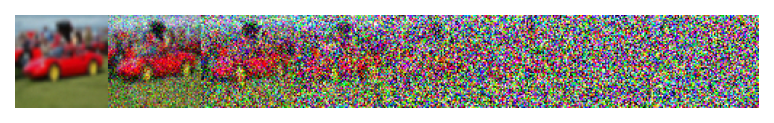

In [10]:
# Forward process
for image in batch[:5]:
    _ = forward_diffusion_viz(image.unsqueeze(dim=0), num_images=7, dpi=150, interleave=False)

In [11]:
# Training
from unet import UNet

model = UNet(ch_mults=(1, 2, 1, 1))

n_params = sum(p.numel() for p in model.parameters())
print(
    f"Number of parameters: {n_params:,}"
)

Number of parameters: 9,139,651


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
# Move everything to GPU
model.to(device)

UNet(
  (image_proj): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_emb): TimeEmbedding(
    (lin1): Linear(in_features=64, out_features=256, bias=True)
    (act): Swish()
    (lin2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down): ModuleList(
    (0-1): 2 x DownBlock(
      (res): ResidualBlock(
        (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
        (act1): Swish()
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
        (act2): Swish()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (shortcut): Identity()
        (time_emb): Linear(in_features=256, out_features=64, bias=True)
        (time_act): Swish()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (attn): Identity()
    )
    (2): Downsample(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    

In [14]:
# Training loop
sqrt_alphas_bar = sqrt_alphas_bar.to(device)
alphas = alphas.to(device)
alphas_bar = alphas_bar.to(device)
alphas_bar_prev = alphas_bar_prev.to(device)
sqrt_recip_alphas = sqrt_recip_alphas.to(device)
sqrt_one_minus_alpha_bar = sqrt_one_minus_alpha_bar.to(device)
posterior_variance = posterior_variance.to(device)
betas = betas.to(device)

In [15]:
criterion = torch.nn.MSELoss()

In [16]:
# Cosine Annealing for the learning rate, with a warmup period
base_lr = 0.0006 # Maximum learning rate we will use
epochs = 10 # Total number of epochs
T_max = epochs # Number of epochs for Cosine Annealing. We do only one cycle
warmup_epochs = 2 # Number of warm-up epochs

In [17]:
optimizer = Adam(model.parameters(), lr=base_lr)
scheduler = CosineAnnealingLR(
    optimizer=optimizer,
    T_max=T_max - warmup_epochs,
    eta_min=base_lr/10 # Starting value for the LR
)

In [18]:
# We will use this noise to generate some images during training to check
# where we stand
fixed_noise = torch.randn((1, 3, img_size, img_size), device=device)

In [19]:
alpha = 0.1  # Smoothing factor
ema_loss = None  # Initialize EMA loss

100%|██████████| 188/188 [00:48<00:00,  3.91it/s]


epoch 1: loss: 0.053, lr: 0.000300


100%|██████████| 188/188 [00:47<00:00,  3.92it/s]


epoch 2: loss: 0.030, lr: 0.000600


100%|██████████| 188/188 [00:47<00:00,  3.96it/s]


epoch 3: loss: 0.027, lr: 0.000579


100%|██████████| 188/188 [00:47<00:00,  3.96it/s]


epoch 4: loss: 0.022, lr: 0.000521


100%|██████████| 188/188 [00:47<00:00,  3.96it/s]


epoch 5: loss: 0.024, lr: 0.000433


100%|██████████| 188/188 [00:48<00:00,  3.90it/s]


epoch 6: loss: 0.022, lr: 0.000330


100%|██████████| 188/188 [00:48<00:00,  3.89it/s]


epoch 7: loss: 0.021, lr: 0.000227


100%|██████████| 188/188 [00:47<00:00,  3.96it/s]


epoch 8: loss: 0.020, lr: 0.000139


100%|██████████| 188/188 [00:47<00:00,  3.94it/s]


epoch 9: loss: 0.022, lr: 0.000081


100%|██████████| 188/188 [00:48<00:00,  3.87it/s]


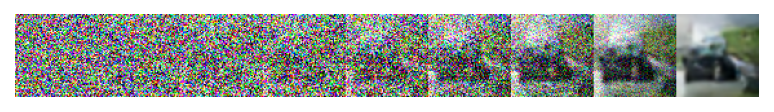

epoch 10: loss: 0.020, lr: 0.000060


In [ ]:
for epoch in range(epochs):
    
    if epoch < warmup_epochs:
        # Linear warm-up
        lr = base_lr * (epoch + 1) / warmup_epochs
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    else:
        # Cosine Annealing after warm-up
        scheduler.step()
        
    current_lr = optimizer.param_groups[0]['lr']
    
    for batch, _ in tqdm(dataloader):
        
        batch = batch.to(device)
        bs = batch.shape[0]
        
        optimizer.zero_grad()
        
        t = torch.randint(0, T, (batch.shape[0],), device=device).long()
        
        # Generate targets for the UNet and apply them to the images
        noise = torch.randn_like(batch, device=device)
        
        x_noisy = (
            sqrt_alphas_bar[t].view(bs, 1, 1, 1) * batch + 
            sqrt_one_minus_alpha_bar[t].view(bs, 1, 1, 1) * noise
        )
        
        noise_pred = model(x_noisy, t)
        loss = criterion(noise, noise_pred)
        
        loss.backward()
        optimizer.step()
        
        if ema_loss is None:
            # First batch
            ema_loss = loss.item()
        else:
            # Exponential moving average of the loss
            ema_loss = alpha * loss.item() + (1 - alpha) * ema_loss
        
        
    if epoch == epochs - 1:
        with torch.no_grad():
            imgs = make_inference(fixed_noise, device, model, return_all=True)
            fig = display_sequence([imgs[0].squeeze(dim=0)] + [x.squeeze(dim=0) for x in imgs[63::64]], nrow=9, dpi=150)
            plt.show(fig)
        os.makedirs("diffusion_output_long", exist_ok=True)
        fig.savefig(f"diffusion_output_long/frame_{epoch:05d}.png")
        
    print(f"epoch {epoch+1}: loss: {ema_loss:.3f}, lr: {current_lr:.6f}")

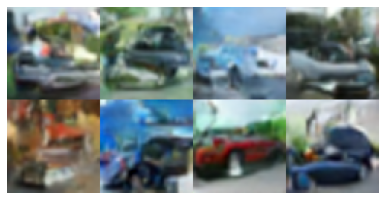

In [23]:
# Generate some images
input_noise = torch.randn((8, 3, img_size, img_size), device=device)
imgs = make_inference(input_noise,device, model)
_ = display_sequence(imgs, dpi=75, nrow=4)